In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from joblib import Parallel, delayed

time_conv = 977.79222167

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [3]:
from numba import njit

@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

@njit
def _binned_average(x, y, bins, ave=True):
    N = len(bins)
    
    sum_x_in_bin = np.zeros(N-1)
    sum_y_in_bin = np.zeros(N-1)
    N_in_bin = np.zeros(N-1)
    
    for i in range(len(x)):
        this_x = x[i]
        for j in range(N-1):
            if this_x > bins[j] and this_x < bins[j+1]:
                sum_x_in_bin[j] += x[i]
                sum_y_in_bin[j] += y[i]
                N_in_bin[j] += 1
    
    for j in range(N-1):
        if N_in_bin[j] > 0:
            sum_x_in_bin[j] /= N_in_bin[j]
            if ave:
                sum_y_in_bin[j] /= N_in_bin[j]
        else:
            sum_x_in_bin[j] = np.nan
            sum_y_in_bin[j] = np.nan
    
    return sum_x_in_bin, sum_y_in_bin
    
def binned_average(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)

    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins)

def binned_sum(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)
    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins, ave=False)

In [58]:
# sn0_list = []
# idx_list = np.arange(400, 600, 1)
# fields=['Coordinates', 'Velocities', 'Masses', 'Acceleration']
# parttype=2
# for idx in tqdm(idx_list):
#     sn0 = read_snap(idx, 0, parttype=[0, 2, 3], fields=None)
#     sn0_list.append(sn0)


In [59]:
# def get_cyl(sn, pt, center=np.array([200, 200, 200])):
#     part = getattr(sn, 'part'+str(pt))
#     pos = part.pos.value - center
#     vel = part.vel.value
    
#     R = np.linalg.norm(pos[:,:2], axis=1)
#     phi = np.arctan2(pos[:,1], pos[:,0])
#     z = pos[:,2]
    
#     cosphi = pos[:,0]/R
#     sinphi = pos[:,1]/R
    
#     vR = cosphi * vel[:,0] + sinphi * vel[:,1]
#     vphi = cosphi * vel[:,1] - sinphi * vel[:,0]
#     vz = vel[:,2]
    
#     return np.transpose([R, phi, z, vR, vphi, vz])

In [55]:
# for i,idx in enumerate(tqdm(idx_list)):
def compute_torques(i, sim=0, center=np.array([0., 0., 0.])):
#     sn = sn0_list[i]
    sn = read_snap(i, sim, parttype=[0, 1, 2, 3, 4], fields=None)
    
    if sn.NumPart_Total[0] > 0:
        gas_pos = sn.part0.pos.value - center
        gas_acc = sn.part0.acce
        gas_acc = my_mult(sn.part0.mass.value, gas_acc)
        torque_gas = np.cross(gas_pos, gas_acc)
        tz_gas = np.sum(torque_gas[:,2])
    else:
        tz_gas = 0.0
    
    if sn.NumPart_Total[4] > 0:
        star_pos = sn.part4.pos.value - center
        star_acc = sn.part4.acce
        star_acc = my_mult(sn.part4.mass.value, star_acc)
        torque_star = np.cross(star_pos, star_acc)
        tz_star = np.sum(torque_star[:,2])
    else:
        tz_star = 0.0
        
    halo_pos = sn.part1.pos.value - center
    disk_pos = sn.part2.pos.value - center
    bulge_pos = sn.part3.pos.value - center
    
    halo_acc = sn.part1.acce
    disk_acc = sn.part2.acce
    bulge_acc = sn.part3.acce

    if sn.MassTable[1] > 0.0:
        halo_acc *= sn.MassTable[1]
    else:
        halo_acc *= sn.part1.mass.value
    
    if sn.MassTable[2] > 0.0:
        disk_acc *= sn.MassTable[2]
    else:
        disk_acc *= sn.part2.mass.value
        
    if sn.MassTable[3] > 0.0:
        bulge_acc *= sn.MassTable[3]
    else:
        bulge_acc *= sn.part3.mass.value
    
    torque_halo = np.cross(halo_pos, halo_acc)
    torque_disk = np.cross(disk_pos, disk_acc)
    torque_bulge = np.cross(bulge_pos, bulge_acc)
    
    tz_halo = np.sum(torque_halo[:,2])
    tz_disk = np.sum(torque_disk[:,2])
    tz_bulge = np.sum(torque_bulge[:,2])
    
    time = sn.Time.value
    
    return time, tz_gas, tz_halo, tz_disk, tz_bulge, tz_star


In [5]:
idx_list = np.arange(400, 600, 1)
n_proc=24
ans = Parallel(n_jobs=n_proc) (delayed(compute_torques)(i) for i in tqdm(idx_list))

A Jupyter Widget

In [56]:
idx_list = np.arange(400, 600, 1)
n_proc=24
ans1 = Parallel(n_jobs=n_proc) (delayed(compute_torques)(i, sim=1, center=np.array([200., 200., 200.])) for i in tqdm(idx_list))

A Jupyter Widget

In [7]:
ans = np.array(ans)
time_list = ans[:,0]
tz_halo = ans[:,2]
tz_disk = ans[:,3]
tz_bulge = ans[:,4]

In [57]:
ans1 = np.array(ans1)
time_list1 = ans1[:,0]
tz_gas1 = ans1[:,1]
tz_halo1 = ans1[:,2]
tz_disk1 = ans1[:,3]
tz_bulge1 = ans1[:,4]
tz_star1 = ans1[:,5]

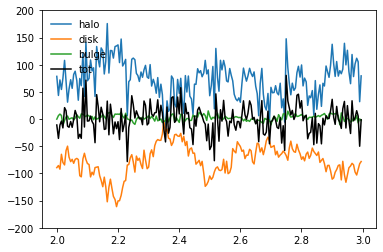

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(time_list, tz_halo, label='halo')
# ax.plot(time_list[:32], tz_bar, label='bar')
ax.plot(time_list, tz_disk, label='disk')
ax.plot(time_list, tz_bulge, label='bulge')
ax.plot(time_list, tz_halo + tz_disk + tz_bulge, label='tot', c='k')

ax.legend(frameon=False)

# ax.set(ylim=(-5000, 5000))
ax.set(ylim=(-200, 200))

plt.show()

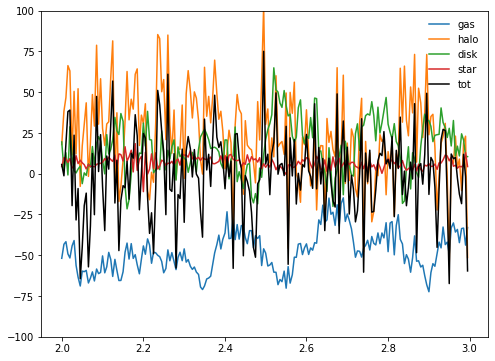

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_list1, tz_gas1, label='gas')
ax.plot(time_list1, tz_halo1, label='halo')
ax.plot(time_list1, tz_disk1, label='disk')
# ax.plot(time_list1, tz_bulge1, label='bulge')
ax.plot(time_list1, tz_star1, label='star')
ax.plot(time_list1, tz_gas1 + tz_halo1 + tz_disk1 + tz_bulge1 + tz_star1, label='tot', c='k')

ax.legend(frameon=False)

ax.set(ylim=(-100, 100))

plt.show()

In [21]:
def compute_torque_radial_profile(i, pt, sim=0, center=np.array([0., 0., 0.])):
#     sn = sn0_list[i]
    sn = read_snap(i, sim, parttype=pt, fields=None)
    
    part = getattr(sn, 'part'+str(pt))
    
    pos = part.pos.value - center
    acc = part.acce
    if sn.MassTable[pt] > 0.0:
        acc *= sn.MassTable[pt]
    else:
        acc = my_mult(part.mass.value, acc)
    
    torque = np.cross(pos, acc)
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    
    Rlist, tzlist = binned_sum(R, torque[:,2], 0.2)
    tzlist /= 0.2
    return Rlist, tzlist
    

In [16]:
idx_list = [400, 450, 500, 550, 600]
Rlist_list = []
tzlist_list = []
for idx in tqdm(idx_list):
    Rlist, tzlist = compute_torque_radial_profile(idx, 2)
    Rlist_list.append(Rlist)
    tzlist_list.append(tzlist)


A Jupyter Widget

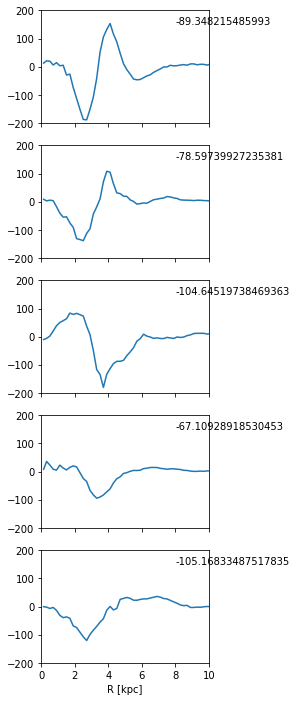

In [63]:
fig, ax = plt.subplots(5, 1, figsize=(3, 12), sharex=True)
for i,x in enumerate(ax):
    x.plot(Rlist_list[i], tzlist_list[i])
    x.set_xlim(0, 10)
    x.set_ylim(-200, 200)
    
    tot = np.nancumsum(tzlist_list[i])[-1] * 0.2
    x.text(8, 150, str(tot))

ax[-1].set(xlabel='R [kpc]')
plt.show()

In [30]:
idx_list = [400, 450, 500, 550, 600]
Rlist_gas_list = []
Rlist_disk_list = []
tzlist_gas_list = []
tzlist_disk_list = []
for idx in tqdm(idx_list):
    Rlist, tzlist = compute_torque_radial_profile(idx, 0, sim=1, center=np.array([200., 200., 200.]))
    Rlist_gas_list.append(Rlist)
    tzlist_gas_list.append(tzlist)
    
    Rlist, tzlist = compute_torque_radial_profile(idx, 2, sim=1, center=np.array([200., 200., 200.]))
    Rlist_disk_list.append(Rlist)
    tzlist_disk_list.append(tzlist)


A Jupyter Widget

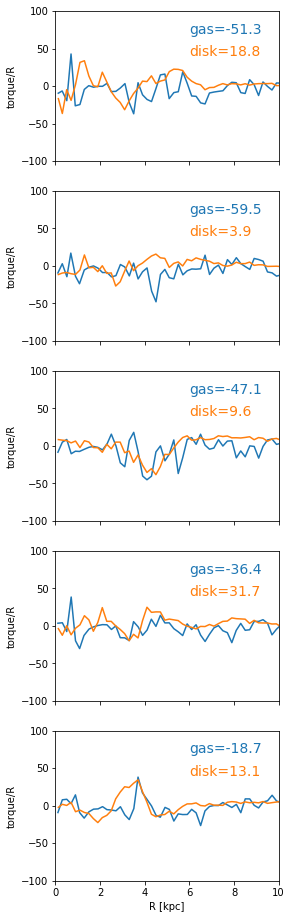

In [50]:
fig, ax = plt.subplots(5, 1, figsize=(4, 16), sharex=True)
for i,x in enumerate(ax):
    lgas = x.plot(Rlist_gas_list[i], tzlist_gas_list[i])
    ldisk = x.plot(Rlist_disk_list[i], tzlist_disk_list[i])
    x.set_xlim(0, 10)
    x.set_ylim(-100, 100)
    
    tot = np.nancumsum(tzlist_gas_list[i])[50] * 0.2
    x.text(6, 70, "gas={0:.1f}".format(tot), c=lgas[0].get_color(), size=14)
    
    tot = np.nancumsum(tzlist_disk_list[i])[50] * 0.2
    x.text(6, 40, "disk={0:.1f}".format(tot), c=ldisk[0].get_color(), size=14)
    x.set_ylabel('torque/R')# [1E10 Msun (km/s)^2 / kpc]')
    
ax[-1].set_xlabel('R [kpc]')
    
plt.show()

In [29]:
Rlist_disk_list[0]

array([240.62178771,          nan,          nan, ...,          nan,
                nan, 690.35005251])